## Basic Python Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import WordCloud
import re

## Natural Language Processing Libraries

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Scikit-Learn (Machine Learning Library for Python)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## Evaluation Metrics

In [4]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix

In [48]:
df_train = pd.read_csv("train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("val.txt",delimiter=';',names=['text','label'])

In [49]:
df = pd.concat([df_train,df_val])
df.reset_index(inplace=True,drop=True)

In [50]:
print("Shape of the DataFrame:",df.shape)
df.sample(5)

Shape of the DataFrame: (18000, 2)


,text,label
976,i feel kind of alone and helpless in,sadness
17072,i love your style and feel very comfortable wi...,joy
14098,i was little i always had this exciting jitter...,joy
15082,i just want the best for that boy maybe i can ...,anger
8044,i frantically try to get it done and now feel ...,fear


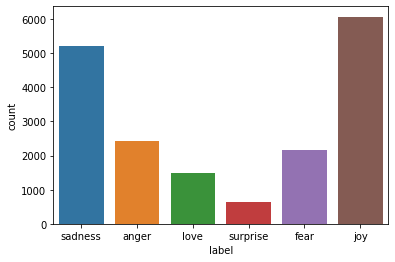

In [51]:
sns.countplot(df.label)

In [52]:
dist_labels={}
for num,key in enumerate(list(set(df.label))):
    dist_labels[key]=num   
print(dist_labels)

{'anger': 0, 'fear': 1, 'joy': 2, 'sadness': 3, 'love': 4, 'surprise': 5}


In [53]:
df['label']=df['label'].map(dist_labels)
df.head()

,text,label
0,i didnt feel humiliated,3
1,i can go from feeling so hopeless to so damned...,3
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,4
4,i am feeling grouchy,0


## Data Pre-processing

In [54]:
#object of WordNetLemmatizer
lm = WordNetLemmatizer()
def clean_text(text):
#     corpus = []
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [lm.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
#     corpus.append(' '.join(str(x) for x in text))
    return ' '.join(str(x) for x in text)

corpus = df['text'].apply(lambda x:clean_text(x))

## Word Cloud

In [55]:
corpus.head()

0                                didnt feel humiliated
1    go feeling hopeless damned hopeful around some...
2            im grabbing minute post feel greedy wrong
3    ever feeling nostalgic fireplace know still pr...
4                                      feeling grouchy
Name: text, dtype: object

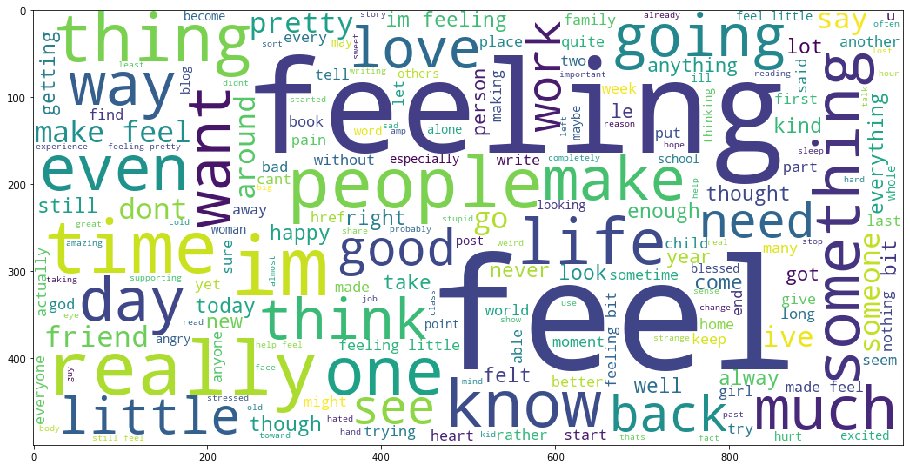

In [56]:
plt.figure(figsize=(20,8))
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

## Bag of Words

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
x = tfidf_vect.fit_transform(corpus)
y = df.label

In [58]:
x

<18000x14295 sparse matrix of type '<class 'numpy.float64'>'
	with 162115 stored elements in Compressed Sparse Row format>

## GridSearchCV

In [17]:
# parameters = {'max_features': ('auto','sqrt'),
#              'n_estimators': [500, 1000, 1500],
#              'max_depth': [5, 10, None],
#              'min_samples_split': [5, 10, 15],
#              'min_samples_leaf': [1, 2, 5, 10],
#              'bootstrap': [True, False]}

parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [500],
             'max_depth': [5, None],}

In [18]:
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(x,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

## Check all combination of parameter resoponse

In [19]:
def print_result(results):
    print("best param are {}".format(results.best_params_))
    means=results.cv_results_['mean_test_score']
    stds=results.cv_results_['std_test_score']
    for mean,std,param in zip(means,stds,results.cv_results_['params']):
        print("{} (+/-) {} for {}".format(round(mean,3),round(std,2),param))

In [20]:
print_result(grid_search)

best param are {'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}
0.338 (+/-) 0.0 for {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}
0.338 (+/-) 0.0 for {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}
0.887 (+/-) 0.01 for {'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}
0.884 (+/-) 0.01 for {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 500}


In [21]:
# Best parameters
grid_search.best_params_

{'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}

In [26]:
rfc = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],
                                      max_depth=grid_search.best_params_['max_depth'],
                                      n_estimators=grid_search.best_params_['n_estimators'],
                                      )
rfc.fit(x,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Test Data Transformation 

In [59]:
test_df = pd.read_csv('test.txt',delimiter=';',names=['text','label'])
X_test,y_test = test_df.text,test_df.label
#encode the labels
test_df = y_test.map(dist_labels)
#pre-processing of text
test_corpus = X_test.apply(lambda x:clean_text(x))
#convert text data into vectors
testdata = tfidf_vect.transform(test_corpus)
#predict the target
predictions = rfc.predict(testdata)

## Model Evaluation

Accuracy_score:  0.885
Precision_score:  0.885
Recall_score:  0.885
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       275
           1       0.87      0.88      0.87       224
           2       0.89      0.92      0.90       695
           3       0.94      0.92      0.93       581
           4       0.75      0.69      0.72       159
           5       0.66      0.61      0.63        66

    accuracy                           0.89      2000
   macro avg       0.83      0.82      0.83      2000
weighted avg       0.88      0.89      0.88      2000



<Figure size 1080x720 with 0 Axes>

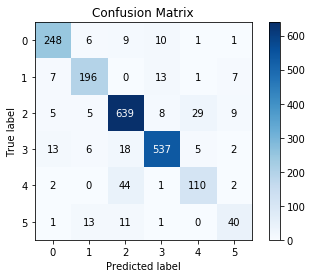

In [68]:
# rcParams['figure.figsize'] = 10,5
plt.figure(figsize=(15,10))
plot_confusion_matrix(test_df,predictions)
acc_score = accuracy_score(test_df,predictions)
pre_score = precision_score(test_df,predictions,average='micro')
rec_score = recall_score(test_df,predictions,average='micro')
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(test_df,predictions)
print(cr)